# Jane Street Kaggle Competition

Adrian & Joseph

# Dataset 

This dataset contains an anonymized set of features, feature_{0...129}, representing real stock market data. Each row in the dataset represents a trading opportunity, for which you will be predicting an action value: 1 to make the trade and 0 to pass on it. Each trade has an associated weight and resp, which together represents a return on the trade. The date column is an integer which represents the day of the trade, while ts_id represents a time ordering. In addition to anonymized feature values, you are provided with metadata about the features in features.csv.
In the training set, train.csv, you are provided a resp value, as well as several other resp_{1,2,3,4} values that represent returns over different time horizons. These variables are not included in the test set. Trades with weight = 0 were intentionally included in the dataset for completeness, although such trades will not contribute towards the scoring evaluation. We created an action column associated with the trading opportunities as you will see later in the script on a condition of when the weight variable is zero or not   
These libraries are the libraries more or less to build and run these models.
Since this dataset is more than 2 million rows, doing EDA and fitting a model takes a good amount of time so we reduced the number of rows by taking every tenth row during our analysis. Once we found our model, we scaled the model up to the full data set.




In [2]:
import os
import time

import seaborn as sns
import matplotlib.pyplot as plt 
import numpy as np 
import pandas as pd

import scipy.cluster.hierarchy as sch
from scipy.cluster.hierarchy import fcluster
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans


from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split


from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score 
from sklearn.metrics import confusion_matrix, classification_report

from mlinsights.mlmodel import ClassifierAfterKMeans


from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report,confusion_matrix

import math
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import RobustScaler 

from scipy import stats


Using TensorFlow backend.


In [3]:
def remove_collinear_features(x, threshold):
    '''
    Objective:
        Remove collinear features in a dataframe with a correlation coefficient
        greater than the threshold. Removing collinear features can help a model 
        to generalize and improves the interpretability of the model.

    Inputs: 
        x: features dataframe
        threshold: features with correlations greater than this value are removed

    Output: 
        dataframe that contains only the non-highly-collinear features
    '''

    # Calculate the correlation matrix
    corr_matrix = x.corr()
    iters = range(len(corr_matrix.columns) - 1)
    drop_cols = []

    # Iterate through the correlation matrix and compare correlations
    for i in iters:
        for j in range(i+1):
            item = corr_matrix.iloc[j:(j+1), (i+1):(i+2)]
            col = item.columns
            row = item.index
            val = abs(item.values)

            # If correlation exceeds the threshold
            if val >= threshold:
                # Print the correlated features and the correlation value
                #print(col.values[0], "|", row.values[0], "|", round(val[0][0], 2))
                drop_cols.append(col.values[0])

    # Drop one of each pair of correlated columns
    drops = set(drop_cols)
    x = x.drop(columns=drops)
    print('Removed Columns {}'.format(drops))
    return x

#  Reducing the memory of the data for faster processing
def reduce_memory_usage(df):   
    start_memory = df.memory_usage().sum() / 1024**2
    print(f"Memory usage of dataframe is {start_memory} MB")
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != 'object':
            c_min = df[col].min()
            c_max = df[col].max()
            
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
                    
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    pass
        else:
            df[col] = df[col].astype('category')
    
    end_memory = df.memory_usage().sum() / 1024**2
    print(f"Memory usage of dataframe after reduction {end_memory} MB")
    print(f"Reduced by {100 * (start_memory - end_memory) / start_memory} % ")
    return df

In [4]:
# import original data and measure time 
start_time = time.time()
df = pd.read_csv('train.csv')
features = pd.read_csv('~/Desktop/Kaggle Comp-Jane Street/features.csv')
print("--- %s seconds ---" % (time.time() - start_time))

--- 58.70051670074463 seconds ---


In [5]:
len(df)

2390491

# Feature engineering : 

## Extract only 1/10 of data to increase the process speed / scaled

In [10]:
start_time = time.time() 
new_df = []

#for i in range(1, round( len(df)/10 ) ):
#     new_df[i] =  df.iloc[i*10]

for i in range(1, round( len(df)/10 ) ):
     row10 = df.iloc[i*10]
     new_df.append(row10)

new_df = pd.DataFrame(new_df)
new_df.head()        

print("--- %s seconds ---" % (time.time() - start_time))

--- 56.67313599586487 seconds ---


In [103]:
len(new_df)

239048

In [6]:
new_df.head()

,date,weight,resp_1,resp_2,resp_3,resp_4,resp,feature_0,feature_1,feature_2,...,feature_121,feature_122,feature_123,feature_124,feature_125,feature_126,feature_127,feature_128,feature_129,ts_id
10,0.0,0.109651,0.006899,0.003405,0.000134,-0.003040,-0.000690,1.0,-3.172026,-3.093182,...,NaN,2.324290,4.881133,2.115830,6.337250,3.059392,5.350729,2.755876,4.968388,10.0
20,0.0,5.249721,0.004579,0.005255,0.003402,0.003055,0.005213,-1.0,-1.316192,-1.691630,...,NaN,1.322001,4.704479,2.030342,8.664091,2.743058,7.060875,1.650928,4.904831,20.0
30,0.0,13.419400,0.005940,0.006978,0.005864,0.009678,0.010908,1.0,-3.172026,-3.093182,...,NaN,0.909863,3.467216,1.848538,7.622972,2.486547,6.124114,1.601317,4.452935,30.0
40,0.0,1.159040,-0.008460,-0.009266,0.026637,0.109863,0.074078,-1.0,2.112653,0.008681,...,NaN,12.757619,3.887723,9.988868,3.589536,13.292899,3.291133,12.821835,3.291217,40.0
50,0.0,0.666351,0.008273,0.007583,0.015846,0.025220,0.019191,-1.0,0.383771,-0.415101,...,NaN,4.984380,10.391276,8.831754,23.017784,10.145836,18.969491,6.472845,12.143004,50.0


In [7]:
new_df.shape

(239048, 138)

# Adding return column

Firstly, we added a ‘return’ column, which is a ‘weight’ multiplied by ‘resp’ values in each row. 
Next, we calculated the ‘action’ column to the dataset, which is determined by the ‘return’ value from the previous step. If the ‘return’ value is greater than zero, then ‘action’ value is equal to 1 whereas zero for all other values.


In [6]:
# Scaling - Scaling means when we had to go back and use the full data set to see 
# if the models held up to a larger quantity of data 

df['return'] = df['resp']*df['weight']

In [11]:
# return
new_df['return'] = new_df['resp']*new_df['weight']

new_df['return'] = new_df['resp']*new_df['weight']
new_df.head()

,date,weight,resp_1,resp_2,resp_3,resp_4,resp,feature_0,feature_1,feature_2,...,feature_122,feature_123,feature_124,feature_125,feature_126,feature_127,feature_128,feature_129,ts_id,return
10,0.0,0.109651,0.006899,0.003405,0.000134,-0.003040,-0.000690,1.0,-3.172026,-3.093182,...,2.324290,4.881133,2.115830,6.337250,3.059392,5.350729,2.755876,4.968388,10.0,-0.000076
20,0.0,5.249721,0.004579,0.005255,0.003402,0.003055,0.005213,-1.0,-1.316192,-1.691630,...,1.322001,4.704479,2.030342,8.664091,2.743058,7.060875,1.650928,4.904831,20.0,0.027366
30,0.0,13.419400,0.005940,0.006978,0.005864,0.009678,0.010908,1.0,-3.172026,-3.093182,...,0.909863,3.467216,1.848538,7.622972,2.486547,6.124114,1.601317,4.452935,30.0,0.146382
40,0.0,1.159040,-0.008460,-0.009266,0.026637,0.109863,0.074078,-1.0,2.112653,0.008681,...,12.757619,3.887723,9.988868,3.589536,13.292899,3.291133,12.821835,3.291217,40.0,0.085859
50,0.0,0.666351,0.008273,0.007583,0.015846,0.025220,0.019191,-1.0,0.383771,-0.415101,...,4.984380,10.391276,8.831754,23.017784,10.145836,18.969491,6.472845,12.143004,50.0,0.012788


In [7]:
# Scaling 
df.loc[df['resp'] > 0, 'action'] = 1
df.loc[df['resp'] <= 0, 'action'] = 0

In [12]:
# creating a new column called "action"
new_df.loc[new_df['resp'] > 0, 'action'] = 1
new_df.loc[new_df['resp'] <= 0, 'action'] = 0
new_df.head()

,date,weight,resp_1,resp_2,resp_3,resp_4,resp,feature_0,feature_1,feature_2,...,feature_123,feature_124,feature_125,feature_126,feature_127,feature_128,feature_129,ts_id,return,action
10,0.0,0.109651,0.006899,0.003405,0.000134,-0.003040,-0.000690,1.0,-3.172026,-3.093182,...,4.881133,2.115830,6.337250,3.059392,5.350729,2.755876,4.968388,10.0,-0.000076,0.0
20,0.0,5.249721,0.004579,0.005255,0.003402,0.003055,0.005213,-1.0,-1.316192,-1.691630,...,4.704479,2.030342,8.664091,2.743058,7.060875,1.650928,4.904831,20.0,0.027366,1.0
30,0.0,13.419400,0.005940,0.006978,0.005864,0.009678,0.010908,1.0,-3.172026,-3.093182,...,3.467216,1.848538,7.622972,2.486547,6.124114,1.601317,4.452935,30.0,0.146382,1.0
40,0.0,1.159040,-0.008460,-0.009266,0.026637,0.109863,0.074078,-1.0,2.112653,0.008681,...,3.887723,9.988868,3.589536,13.292899,3.291133,12.821835,3.291217,40.0,0.085859,1.0
50,0.0,0.666351,0.008273,0.007583,0.015846,0.025220,0.019191,-1.0,0.383771,-0.415101,...,10.391276,8.831754,23.017784,10.145836,18.969491,6.472845,12.143004,50.0,0.012788,1.0


In [14]:
# finding missing value
new_df.isnull().sum()

date             0
weight           0
resp_1           0
resp_2           0
resp_3           0
              ... 
feature_128    178
feature_129    178
ts_id            0
return           0
action           0
Length: 140, dtype: int64

In [8]:
# Scaling 
df['action'].groupby(df['action']).agg('count')

action
0.0    1185517
1.0    1204974
Name: action, dtype: int64

In [10]:
new_df['action'].groupby(new_df['action']).agg('count')

action
0.0    118561
1.0    120487
Name: action, dtype: int64

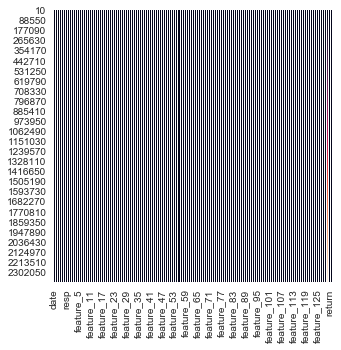

In [110]:
# heatmap
plt.subplots(figsize=(5,5))
sns.heatmap(new_df,  cbar=False)

# Missing data management

The dataset contains missing data and it is replaced by the median value of each column.
To fill in the missing values we choose to use the median values of each feature. Our reasoning for this was because the median value doesn’t get pulled with outliers like how using the mean would be. We didn’t want to delete rows on the full dataset because it is a time series data. If we chose to use the timeseries element of the dataset we would be missing timesteps. Imputing based on a normal distribution is something to look at but we ultimately didn’t do


In [9]:
# Scaling 
df = df.fillna(df.median())

# no more missing values 
[col for col in df.columns if df[col].isnull().any()]

[]

In [15]:
# Filling values with the median
# Filling with the median value because it gives us a better representation of the data values 
# Also fitting a bidirectional lstm we need to keep all the rows for the sequance 

new_df = new_df.fillna(new_df.median())

# no more missing values 
[col for col in new_df.columns if new_df[col].isnull().any()]

[]

In [13]:
# counting how many of action values
new_df['action'].value_counts()

1.0    120487
0.0    118561
Name: action, dtype: int64

In [16]:
new_df.head()

,date,weight,resp_1,resp_2,resp_3,resp_4,resp,feature_0,feature_1,feature_2,...,feature_123,feature_124,feature_125,feature_126,feature_127,feature_128,feature_129,ts_id,return,action
10,0.0,0.109651,0.006899,0.003405,0.000134,-0.003040,-0.000690,1.0,-3.172026,-3.093182,...,4.881133,2.115830,6.337250,3.059392,5.350729,2.755876,4.968388,10.0,-0.000076,0.0
20,0.0,5.249721,0.004579,0.005255,0.003402,0.003055,0.005213,-1.0,-1.316192,-1.691630,...,4.704479,2.030342,8.664091,2.743058,7.060875,1.650928,4.904831,20.0,0.027366,1.0
30,0.0,13.419400,0.005940,0.006978,0.005864,0.009678,0.010908,1.0,-3.172026,-3.093182,...,3.467216,1.848538,7.622972,2.486547,6.124114,1.601317,4.452935,30.0,0.146382,1.0
40,0.0,1.159040,-0.008460,-0.009266,0.026637,0.109863,0.074078,-1.0,2.112653,0.008681,...,3.887723,9.988868,3.589536,13.292899,3.291133,12.821835,3.291217,40.0,0.085859,1.0
50,0.0,0.666351,0.008273,0.007583,0.015846,0.025220,0.019191,-1.0,0.383771,-0.415101,...,10.391276,8.831754,23.017784,10.145836,18.969491,6.472845,12.143004,50.0,0.012788,1.0


Text(0.5, 1.0, 'Resp Cum Sum over time')

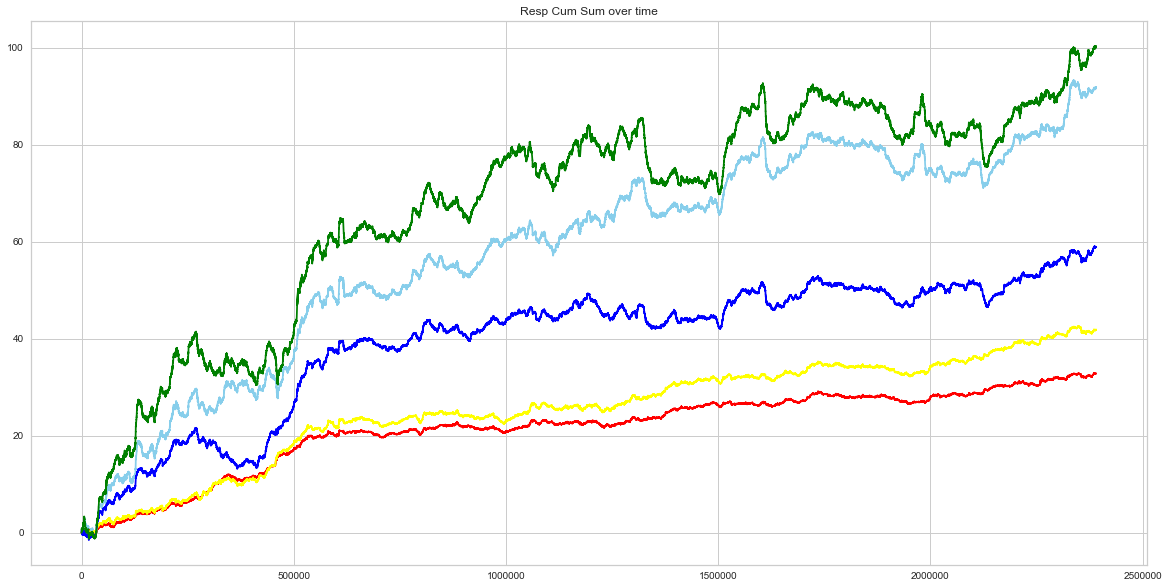

In [115]:
fig = plt.figure(figsize = (20,10))
ax = fig.gca()

plt.plot(new_df.index, new_df['resp'].cumsum(), color='skyblue')
plt.plot(new_df.index, new_df['resp_1'].cumsum(), color='red')
plt.plot(new_df.index, new_df['resp_2'].cumsum(), color='yellow')
plt.plot(new_df.index, new_df['resp_3'].cumsum(), color='blue')
plt.plot(new_df.index, new_df['resp_4'].cumsum(), color='green')
plt.title('Resp Cum Sum over time')

In [12]:
# sum of positive return
sum(i for i in new_df['return'] if i>0)

3783.9778737650868

In [117]:
count_return = new_df.groupby('date')['resp','return']
count_return.last()

,resp,return
date,,
0.0,0.006468,0.009500
1.0,-0.006210,-0.001396
2.0,-0.000766,-0.000000
3.0,-0.004993,-0.001888
4.0,0.003411,0.000721
...,...,...
495.0,0.035562,0.000000
496.0,0.000168,0.000000
497.0,0.001784,0.000000


In [118]:
# import matplotlib.pyplot as plt
 # %matplotlib inline
import pandas as pd
from pandas import DataFrame

result = []

for j in range(0,499):
    date = j 
    num_po = len( list(i for i in new_df[new_df['date']==j ]['return'] if i>=0))
    num_ne = len( list(i for i in new_df[new_df['date']==j ]['return'] if i<0))
    sum_po = sum( list(i for i in new_df[new_df['date']==j ]['return'] if i>=0)) 
    sum_ne = sum( list(i for i in new_df[new_df['date']==j ]['return'] if i<0))
    total = sum_po + sum_ne
    
    result.append([date, num_po, num_ne, sum_po, sum_ne, total])
daily = pd.DataFrame(result, columns=['date', '+num','-num','sum_po','sum_ne', 'total'])
daily.head()


,date,+num,-num,sum_po,sum_ne,total
0,0,351,207,8.765516,-5.550185,3.215331
1,1,585,355,19.337713,-21.386115,-2.048402
2,2,23,0,0.000607,0.000000,0.000607
3,3,428,294,9.349219,-10.224736,-0.875517
4,4,682,349,17.149780,-12.525273,4.624507


In [119]:
print(daily.shape)
daily.corr()

(499, 6)


,date,+num,-num,sum_po,sum_ne,total
date,1.000000,-0.091118,0.087508,-0.008845,-0.026574,-0.053393
+num,-0.091118,1.000000,0.921527,0.835807,-0.809297,-0.052886
-num,0.087508,0.921527,1.000000,0.818902,-0.839267,-0.122967
sum_po,-0.008845,0.835807,0.818902,1.000000,-0.774102,0.234876
sum_ne,-0.026574,-0.809297,-0.839267,-0.774102,1.000000,0.433533
total,-0.053393,-0.052886,-0.122967,0.234876,0.433533,1.000000


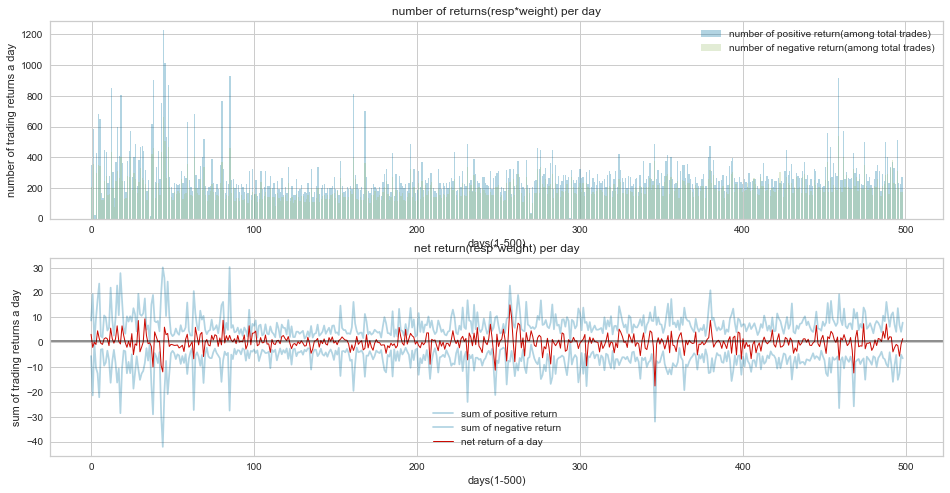

In [120]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.subplots(figsize=(16,8))
plt.subplot(211)
plt.bar(daily['date'], daily['+num'], alpha=0.3)
plt.bar(daily['date'], daily['-num'], alpha=0.3)
plt.legend(('number of positive return(among total trades)','number of negative return(among total trades)'))
plt.title('number of returns(resp*weight) per day')
plt.xlabel('days(1-500)')
plt.ylabel('number of trading returns a day')

plt.subplot(212)
plt.plot(daily['sum_po'], color='b', alpha=0.3)
plt.plot(daily['sum_ne'], color='b', alpha=0.3)
plt.plot(daily['total'], color='r', linewidth=1)
plt.axhline(y=0.5, color='black', linestyle='-', alpha=0.5)
plt.legend(('sum of positive return','sum of negative return', 'net return of a day'))
plt.title('net return(resp*weight) per day')
plt.xlabel('days(1-500)')
plt.ylabel('sum of trading returns a day')

plt.show()


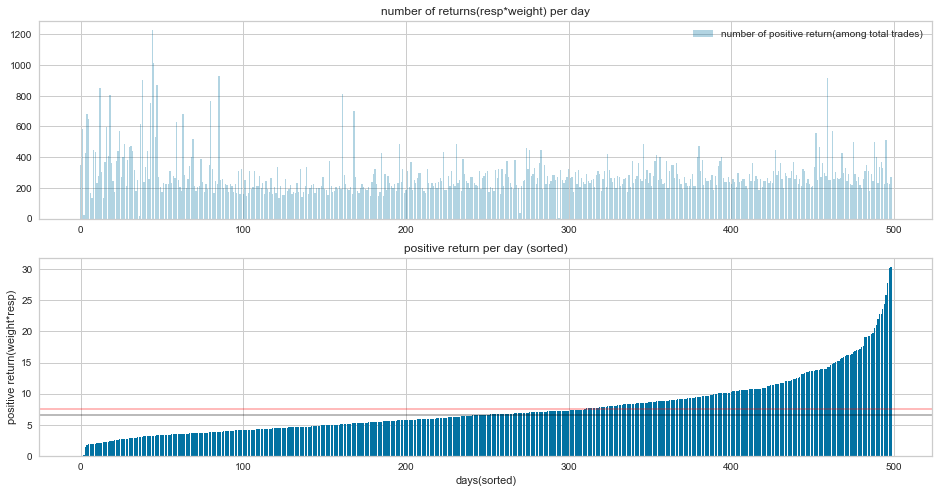

In [121]:
plt.subplots(figsize=(16,8))

plt.subplot(211)
plt.bar(daily['date'], daily['+num'], alpha=0.3)
# plt.bar(daily['date'], daily['-num'], alpha=0.3)
plt.legend(('number of positive return(among total trades)','number of negative return(among total trades)'))
plt.title('number of returns(resp*weight) per day')

daily_sorted = daily.sort_values('sum_po')
daily_sorted.head()
plt.subplot(212)
plt.bar( range(0,499),'sum_po', data=daily_sorted)
plt.title('positive return per day (sorted)')
plt.xlabel('days(sorted)')
plt.ylabel('positive return(weight*resp)')
plt.axhline(y=np.mean(daily['sum_po']) , color='red', linestyle='-', alpha=0.3) # mean
plt.axhline(y=np.median(daily['sum_po']) , color='black', linestyle='-', alpha=0.3) # median

In [122]:
# proportion of positive returns
positive = []
for i in range(0,499):
    po_trade_num = i
    d =round( len( daily[daily['+num']>i ] )  / len(daily['+num']) * 100 , 2)
    positive.append([po_trade_num, d])
positive_plot = pd.DataFrame(positive, columns=['posi_trade_num','%'])
positive_plot.head()

# total sum of positive returns
sumsum = []
for i in range(0,27,1):
    index = i
    d = round( sum(daily_sorted[daily_sorted['sum_po']>i]['sum_po']) / sum(daily_sorted[daily_sorted['sum_po']>0]['sum_po']) * 100 ,2)
    sumsum.append([index, d])
sumsum_plot = pd.DataFrame(sumsum, columns=['index','% sum of returns'])
sumsum_plot.head()

,index,% sum of returns
0,0,100.00
1,1,100.00
2,2,99.66
3,3,97.93
4,4,92.72


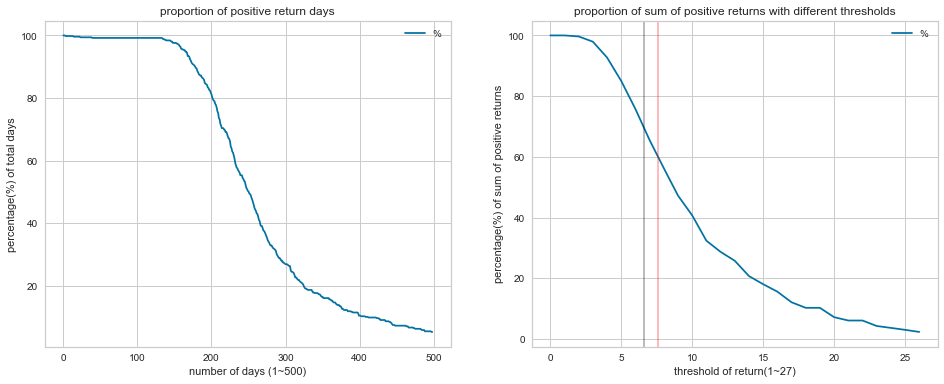

In [123]:
plt.subplots(figsize=(16,6))
plt.subplot(121)
plt.plot(positive_plot['posi_trade_num'], positive_plot['%'])
plt.legend(('% of positive trading'))
plt.xlabel('number of days (1~500)')
plt.ylabel('percentage(%) of total days')
plt.title('proportion of positive return days')

plt.subplot(122)
plt.plot(sumsum_plot['index'], sumsum_plot['% sum of returns'])
plt.legend(('% sum of returns'))
plt.xlabel('threshold of return(1~27)')
plt.ylabel('percentage(%) of sum of positive returns')
plt.title('proportion of sum of positive returns with different thresholds')
plt.axvline(x=np.mean(daily['sum_po']) , color='red', linestyle='-', alpha=0.3) # mean
plt.axvline(x=np.median(daily['sum_po']) , color='black', linestyle='-', alpha=0.3) # median

In [124]:
round( sum(daily_sorted[daily_sorted['sum_po']>5]['sum_po']) / sum(daily_sorted[daily_sorted['sum_po']>0]['sum_po']) * 100 ,2)

84.99

In [125]:
# Evaluation
unique_date = None
pi = sum(return*action)
t = (sum(pi)/sqrt( sum(pi^2)) )*sqrt(250/unique_date)
u = min(max(t,0),6 )*sum(pi)

SyntaxError: invalid syntax (<ipython-input-125-85c3b173c848>, line 3)

In [25]:
len( list(i for i in new_df[new_df['date']==6]['return'] if i>0) )
new_df['date'].nunique() # num of unique date
len( new_df[new_df['date']==6]['return'].value_counts()>0)

248

# Cluster Analysis 

Referencing from another notebook we chose a correlation-based distance and complete linkage to form more ideal clusters. We just wanted to group the features that acted in the same way and not focus too much on outlier variables. We chose hierarchical clustering instead of a DBSCAN just to get a general idea of what variables moved together. “Eyeballing” the dendrogram we made cuts to form clusters we saw fit. We also used an elbow method to optimize the number of clusters.
 
After doing hierarchical clustering on the full dataset, we decided to remove the highly correlated variables based on a threshold to see how the clusters changed. Using the same methods as before we saw the clusters are now even more even. Then we assigned each feature to a cluster based on where we cut the dendrogram.



In [12]:
# Paerson correlation coefficient
corr_mat = df.corr(method='pearson')

# Correlation-based distance
dist = np.sqrt(0.5*(1-corr_mat))

link = sch.linkage(dist,'complete')

<ipython-input-12-a3763922a194>:7: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  link = sch.linkage(dist,'complete')


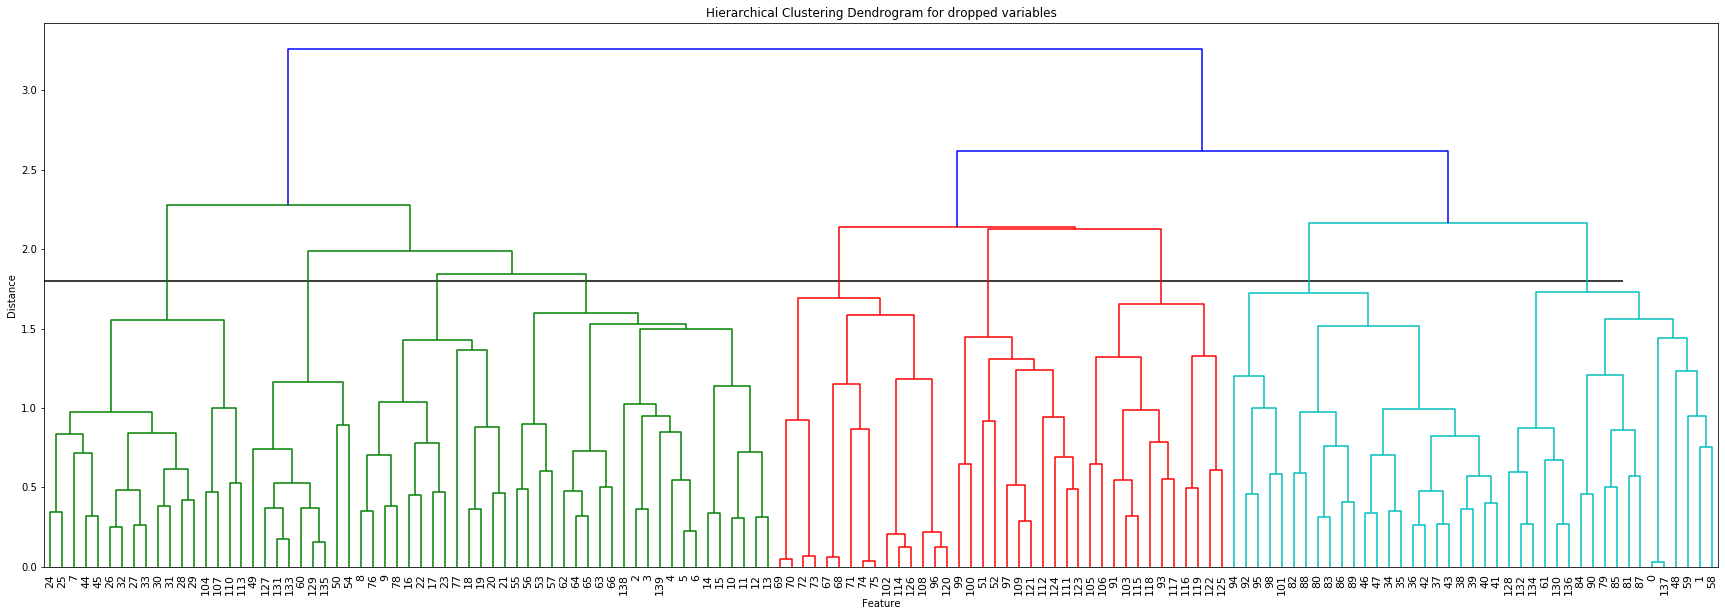

In [13]:

# For Correlation drops 
fig = plt.figure(figsize=(30, 10))

plt.title('Hierarchical Clustering Dendrogram for dropped variables')
plt.xlabel('Feature')
plt.ylabel('Distance')


plt.hlines(1.8,0,1320)
dn = sch.dendrogram(link,leaf_rotation=90.,leaf_font_size=11.)
plt.show()

# 4-9 Clusters seem pretty good because one half of the denogram takes up two clusters 
# They are also fuller at 4-9 clusters 

# Eyeballing I chose 9 

# Variables are going to get grouped together on how they move. 
# For example variables that have an upwards trend will get groupped together 
# The ones that are stationary around the mean would get grouped together 


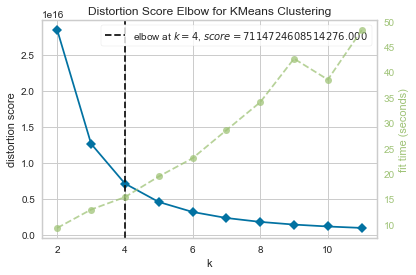

In [128]:
# Elbow Method for K means
# Import ElbowVisualizer
from yellowbrick.cluster import KElbowVisualizer
model = KMeans()
# k is range of number of clusters.
visualizer = KElbowVisualizer(model, k=(2,12), timings= True)
visualizer.fit(new_df)        # Fit data to visualizer
visualizer.show()

# Elbow say 4 

## 2-C : after clean the data, scaling

In [14]:
# Dropping features > .90 correlation 
# Also dropping resp, date, weight, and ts_id becuase we don't need them to fit a model 
new_df = remove_collinear_features(df.drop(['resp','resp_1','resp_2','resp_3','resp_4','ts_id','date','weight'], axis=1), .90


Removed Columns {'feature_12', 'feature_61', 'feature_69', 'feature_35', 'feature_110', 'feature_101', 'feature_128', 'feature_6', 'feature_26', 'feature_28', 'feature_122', 'feature_114', 'feature_127', 'feature_76', 'feature_124', 'feature_107', 'feature_116', 'feature_108', 'feature_4', 'feature_36', 'feature_38', 'feature_40', 'feature_58', 'feature_66', 'feature_68', 'feature_119', 'feature_18', 'feature_126', 'feature_63', 'feature_32', 'feature_24', 'feature_129', 'feature_25', 'feature_113'}


In [15]:
# Paerson correlation coefficient
corr_mat = new_df.corr(method='pearson')

# Correlation-based distance
dist = np.sqrt(0.5*(1-corr_mat))

link = sch.linkage(dist,'complete')

<ipython-input-15-e8b9d59cc65e>:7: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  link = sch.linkage(dist,'complete')


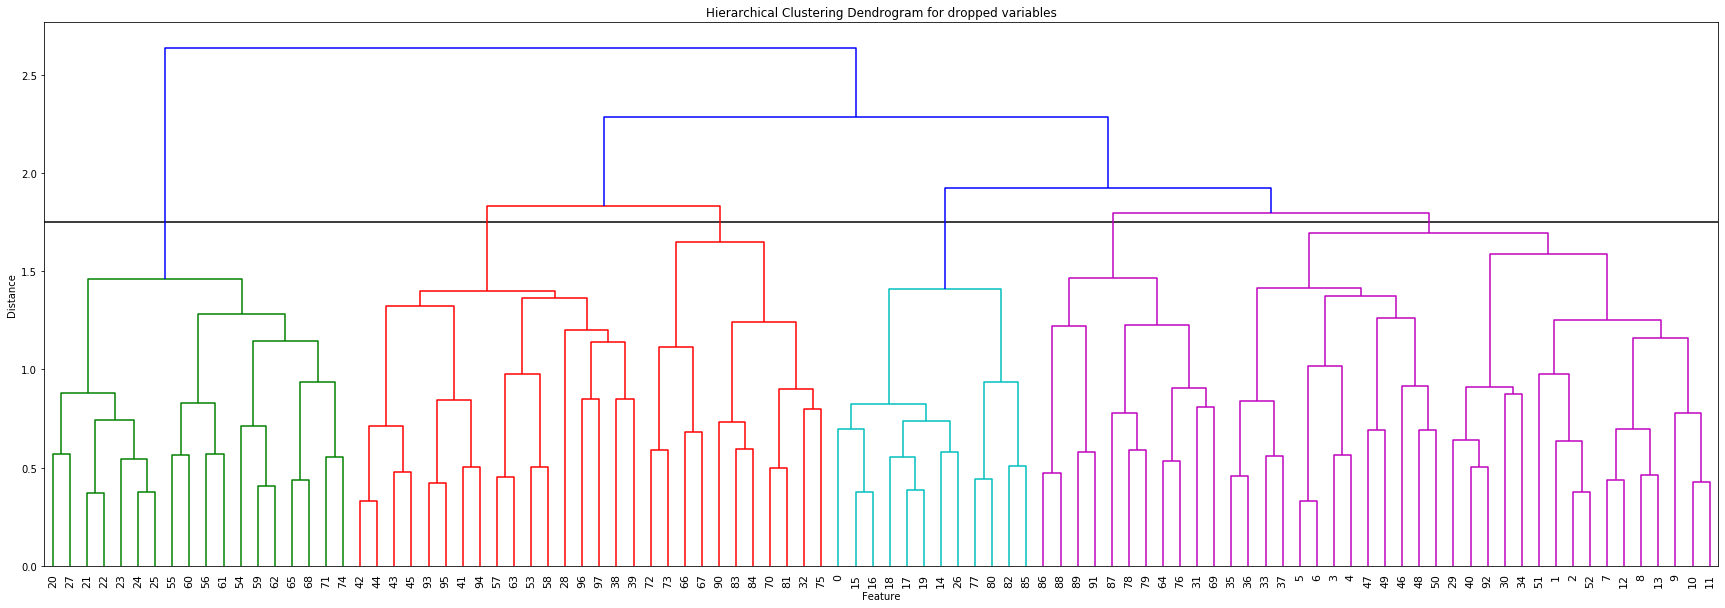

In [16]:
# Clustering again to see what changed 

# Dropping highgly correlated variables makes more even clusters
# Using complete linkage for more "Full" clusters 

# Eyeballing is around 6 

# For Correlation drops 
fig = plt.figure(figsize=(30, 10))

plt.title('Hierarchical Clustering Dendrogram for dropped variables')
plt.xlabel('Feature')
plt.ylabel('Distance')

# where you want to cut the dengram 
plt.hlines(1.75,0,1320)
dn = sch.dendrogram(link,leaf_rotation=90.,leaf_font_size=11.)
plt.show()


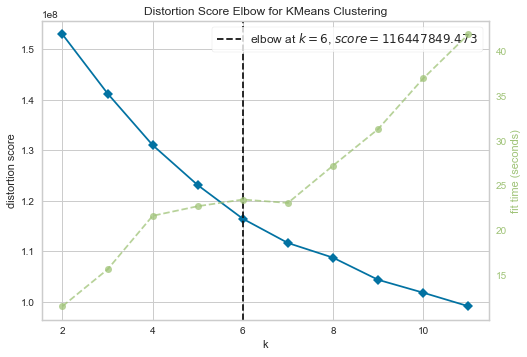

In [33]:

# Import ElbowVisualizer
from yellowbrick.cluster import KElbowVisualizer
model = KMeans()
# k is range of number of clusters.
visualizer = KElbowVisualizer(model, k=(2,12), timings= True)
visualizer.fit(new_df)        # Fit data to visualizer
visualizer.show()

# Elbow says 6

In [54]:
max_d = 1.75
clusters = fcluster(link,t=max_d, criterion='distance')

In [56]:
df_clust = pd.DataFrame({'Cluster':clusters, 'Features':new_df.columns.values.astype('str')})

df_clust.groupby('Cluster').count()

,Features
Cluster,
1,12
2,11
3,30
4,18
5,17
6,11


In [61]:
clust_feat = {}
for k in np.unique(clusters):
    clust_feat[k] = df_clust[df_clust.Cluster == k].Features.values

In [62]:
# Clusters of feautures 
for k in np.unique(clusters):
    print('Cluster_{}'.format(k,2),'->', df_clust[df_clust.Cluster == k].Features.values)

Cluster_1 -> ['feature_0' 'feature_17' 'feature_19' 'feature_20' 'feature_21'
 'feature_22' 'feature_23' 'feature_37' 'feature_97' 'feature_100'
 'feature_103' 'feature_106']
Cluster_2 -> ['feature_44' 'feature_84' 'feature_89' 'feature_96' 'feature_98'
 'feature_99' 'feature_109' 'feature_111' 'feature_112' 'feature_115'
 'feature_118']
Cluster_3 -> ['feature_1' 'feature_2' 'feature_3' 'feature_5' 'feature_7' 'feature_8'
 'feature_9' 'feature_10' 'feature_11' 'feature_12' 'feature_13'
 'feature_14' 'feature_15' 'feature_16' 'feature_42' 'feature_43'
 'feature_46' 'feature_47' 'feature_48' 'feature_49' 'feature_50'
 'feature_53' 'feature_60' 'feature_62' 'feature_64' 'feature_65'
 'feature_67' 'feature_70' 'feature_71' 'feature_120']
Cluster_4 -> ['feature_27' 'feature_29' 'feature_30' 'feature_31' 'feature_33'
 'feature_34' 'feature_39' 'feature_73' 'feature_74' 'feature_75'
 'feature_79' 'feature_80' 'feature_81' 'feature_82' 'feature_85'
 'feature_88' 'feature_91' 'feature_94']
Clus

In [20]:
# Resetting for the seq
# Dont reset on scalled data 
new_df = new_df.reset_index()

del new_df['index']

# Fitting the model:

We split the data into a train/test and scaled the x inputs. Since this is a large data set with many features, we thought it would be good to reduce the number of variables based on some criteria and fit a model. We choose an 85 percent threshold for components used.


In [18]:

y = new_df['action']


train_ratio = 0.75
test_ratio = 0.25

x_train, x_test, y_train, y_test = train_test_split(new_df, y, test_size = 1 - train_ratio)

In [19]:
# Scaling before throwing it in you our ML models

from sklearn.preprocessing import StandardScaler 

scaler = StandardScaler()

scaler.fit(x_train)

training_x = scaler.transform(x_train)
testing_x = scaler.transform(x_test)


In [20]:
len(new_df)
# len(scaledX)


2390491

# 3. Dimensional reduction / reduce the dimension with 95% variance

In [21]:
from sklearn.decomposition import PCA

# Moving it down to .85
pca = PCA(.85)

# fix
PCA_df = pca.fit(training_x)


 # find an optimal number of component, n
# pca.fix(only_features)
# cumsum = np.cumsum(pca.explained_variance_ratio_)
# d = np.argmax(cumsum>= 0.95)+1

# 4. Predict the 'action' with logistic regression (comparison between origianl data and PCA data)


We wanted to fit a simpler model first just to see what the error would look like. We didn’t choose a logistic regression because of the issue of scalability when running on new data.


In [22]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Tradional Log Res 


logmodel = LogisticRegression(solver = 'lbfgs')

# Fitting log reg to traininig data 

logmodel.fit(training_x, y_train.astype('int'))


# Predicitng response on testing data 

predictions = logmodel.predict(testing_x)

print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    296459
         1.0       1.00      1.00      1.00    301164

    accuracy                           1.00    597623
   macro avg       1.00      1.00      1.00    597623
weighted avg       1.00      1.00      1.00    597623



In [23]:
# Training Score 

logmodel.score(training_x, y_train.astype('int'))


1.0

In [24]:
# Testing Score

logmodel.score(testing_x, y_test.astype('int'))

1.0

In [25]:
# Confusion matrix Really accuarate but is it robust?

print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))

[[296459      0]
 [     0 301164]]
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    296459
         1.0       1.00      1.00      1.00    301164

    accuracy                           1.00    597623
   macro avg       1.00      1.00      1.00    597623
weighted avg       1.00      1.00      1.00    597623



# Clustering Logistic Regression:

With cluster analysis we saw that an ideal number of clusters to form are around 6 to 9. This gave us a good idea of how many clusters to fit partitioning k-means clusters then during a logistic regression.


In [28]:

# Clustered Log Res

# Clustering and Log Regs
clk = ClassifierAfterKMeans(e_solver='lbfgs')


clk.fit(x_train, y_train)


y_pred_clust = clk.predict(x_test)

In [29]:
# Not good with clustering
clk.score(x_train, y_train)

0.5998272042336636

In [30]:
# Clustering and Log Regs

# Not as good. 
print(confusion_matrix(y_test, y_pred_clust))
print(classification_report(y_test, y_pred_clust))

[[187593 108866]
 [130705 170459]]
              precision    recall  f1-score   support

         0.0       0.59      0.63      0.61    296459
         1.0       0.61      0.57      0.59    301164

    accuracy                           0.60    597623
   macro avg       0.60      0.60      0.60    597623
weighted avg       0.60      0.60      0.60    597623



In [31]:
# Seeing what number of clusters to use 

dt = []

for cl in range(2, 12):
    clk = ClassifierAfterKMeans(c_n_clusters=cl, e_solver='lbfgs', e_max_iter=1000)
    clk.fit(x_train, y_train)
    sc = clk.score(x_train, y_train)
    dt.append(dict(score=sc, nb_clusters=cl))
    

/Users/adrianharris/PycharmProjects/untitled5/venv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/adrianharris/PycharmProjects/untitled5/venv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-

In [32]:
# Best score is at 7:9 clusters on training but still not good
pd.DataFrame(dt)

,score,nb_clusters
0,0.599827,2
1,0.562958,3
2,0.583218,4
3,0.745719,5
4,0.706408,6
5,0.752726,7
6,0.764372,8
7,0.762270,9
8,0.737297,10
9,0.768361,11


In [94]:
clk = ClassifierAfterKMeans(c_n_clusters=7, e_solver='lbfgs', e_max_iter=700)
clk.fit(x_train, y_train)

y_pred_clust = clk.predict(x_test)

/Users/adrianharris/PycharmProjects/untitled5/venv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [95]:
clk.score(x_train, y_train)

0.7031670069051683

In [96]:
print(confusion_matrix(y_test, y_pred_clust))
print(classification_report(y_test, y_pred_clust))

[[20217  9606]
 [ 8278 21661]]
              precision    recall  f1-score   support

         0.0       0.71      0.68      0.69     29823
         1.0       0.69      0.72      0.71     29939

    accuracy                           0.70     59762
   macro avg       0.70      0.70      0.70     59762
weighted avg       0.70      0.70      0.70     59762



# 7. Neural Network

We chose to use the same dimension methods in our neural network. Using PCA we used the components that explained 95 of variation in the data. We had to scale and transform the data in an array to pass through the network. Since some of these features take on somewhat of a normal distribution using gelu activation in some layers is something that we thought would be interesting to implement.




                                  **Update see final network**

Realized later on the all this model was doing was passing scaled data through the network 
not actually breaking it down to the components 

In [37]:
y = new_df['action']


train_ratio = 0.75
test_ratio = 0.25

x_train, x_test, y_train, y_test = train_test_split(new_df, y, test_size = 1 - train_ratio)

In [53]:
nn_x_train = np.array(x_train)
nn_x_test = np.array(x_test)

nn_y_train = np.array(y_train)
nn_y_test = np.array(y_test)

KeyboardInterrupt: 

In [40]:

from sklearn.preprocessing import StandardScaler 

scaler = StandardScaler()

scaler.fit(nn_x_train)
scaler.fit(nn_x_test)

from sklearn.decomposition import PCA

pca = PCA(.95)

PCA_df = pca.fit(nn_x_train)


In [41]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, Dropout


In [43]:
import tensorflow as tf
from tensorflow.keras import layers
from keras.layers.core import Activation
from tensorflow.keras import activations
from keras.utils.generic_utils import get_custom_objects

def gelu(x):
    cdf = 0.5 * (1.0 + tf.math.erf(x / tf.sqrt(2.0)))
    return x * cdf
get_custom_objects().update({'gelu': Activation(gelu)})

In [44]:
model = Sequential()
model.add(Dense(20, input_dim = len(nn_x_train[0,:]), activation = 'relu')) 
model.add(Dense(10, activation =  'gelu' ))
model.add(Dense(10, activation =  'gelu' ))
model.add(Dropout(0.2))
model.add(Dense(8, activation =  'relu'))
model.add(Dense(1, activation = 'sigmoid'))

In [45]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 20)                1980      
_________________________________________________________________
dense_1 (Dense)              (None, 10)                210       
_________________________________________________________________
dense_2 (Dense)              (None, 10)                110       
_________________________________________________________________
dropout (Dropout)            (None, 10)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 88        
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 9         
Total params: 2,397
Trainable params: 2,397
Non-trainable params: 0
______________________________________________________

In [46]:

model.compile(loss = "binary_crossentropy", optimizer = 'adam', metrics = ['accuracy'])

In [47]:
history = model.fit(x = nn_x_train, y = nn_y_train, validation_split=0.2, epochs = 100, verbose = 1)

Epoch 1/100
44822/44822 [==============================] - 40s 888us/step - loss: 0.0707 - accuracy: 0.9593 - val_loss: 5.2032e-04 - val_accuracy: 0.9999
Epoch 2/100
44822/44822 [==============================] - 40s 898us/step - loss: 0.0012 - accuracy: 0.9997 - val_loss: 1.3634e-04 - val_accuracy: 1.0000
Epoch 3/100
44822/44822 [==============================] - 43s 967us/step - loss: 0.0010 - accuracy: 0.9997 - val_loss: 1.2255e-04 - val_accuracy: 1.0000
Epoch 4/100
44822/44822 [==============================] - 39s 864us/step - loss: 8.2750e-04 - accuracy: 0.9997 - val_loss: 0.0013 - val_accuracy: 0.9997
Epoch 5/100
44822/44822 [==============================] - 42s 938us/step - loss: 8.3849e-04 - accuracy: 0.9998 - val_loss: 9.8496e-04 - val_accuracy: 0.9998
Epoch 6/100
44822/44822 [==============================] - 43s 966us/step - loss: 0.0012 - accuracy: 0.9997 - val_loss: 2.8295e-04 - val_accuracy: 0.9999
Epoch 7/100
44822/44822 [==============================] - 36s 810us/ste

In [ ]:
# Training loss 

plt.plot(history.history['loss'], label = 'loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.legend();

In [49]:
nn_pred = model.predict(nn_x_test)

In [50]:
print(confusion_matrix(nn_y_test, nn_pred.round()))

[[296058      1]
 [    17 301547]]
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    296059
         1.0       1.00      1.00      1.00    301564

    accuracy                           1.00    597623
   macro avg       1.00      1.00      1.00    597623
weighted avg       1.00      1.00      1.00    597623



In [ ]:
print(classification_report(nn_y_test, nn_pred.round()))

In [51]:
accuracy_score(nn_y_test, nn_pred.round())

0.9999698806772832

# Discussion:

You could see that all models have high accuracy, but the neural network would be more robust.
We wanted to build a model that will be robust to new data.
We could probably use different sampling techniques for fitting the models


https://365datascience.com/pca-k-means/
https://www.kaggle.com/oldwine357/removing-highly-correlated-features/comments
https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html
https://paperswithcode.com/method/gelu
https://www.kaggle.com/wongguoxuan/eda-pca-xgboost-classifier-for-beginners
http://www.xavierdupre.fr/app/mlinsights/helpsphinx/notebooks/logistic_regression_clustering.html
https://www.cs.ucr.edu/~eamonn/meaningless.pdf
https://www.fertstert.org/action/showPdf?pii=S0015-0282%2899%2900577-4
https://www.sciencedirect.com/science/article/pii/S1877050919300080
https://www.kaggle.com/vivekanandverma/eda-xgboost-hyperparameter-tuning
https://medium.com/auquan/https-medium-com-auquan-machine-learning-techniques-trading-b7120cee4f05
